In [2]:
import pandas as pd
import numpy as np
import os
os.chdir('..') # to access the raw_data folder
os.getcwd()

'/Users/nicholasbrathwaite/DataW207_AppliedMachineLearning/w207-Final-Project/power_production_w207_final_project_2022'

In [3]:
from utils.utilities import create_is_daytime_feature, get_daylight_times, create_yesterday_max_yield

In [9]:
from scipy.ndimage.interpolation import shift

In [23]:
train_df = pd.read_csv('processed_data/train_preprocessing_df.csv',index_col='DATE_TIME')
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.index = pd.to_datetime(train_df.index,format='%Y-%m-%d %H:%M:%S')
train_df.DATE = pd.to_datetime(train_df.DATE,format='%Y-%m-%d')

In [24]:
test_df = pd.read_csv('processed_data/test_preprocessing_df.csv',index_col='DATE_TIME')
test_df = test_df.drop(columns=['Unnamed: 0'])
test_df.index = pd.to_datetime(test_df.index,format='%Y-%m-%d %H:%M:%S')
test_df.DATE = pd.to_datetime(test_df.DATE,format='%Y-%m-%d')

# Feature Engineering

## add feature for daylight hours ('is_daytime')

In [30]:
train_df = create_is_daytime_feature(train_df)
sunlight_times = get_daylight_times(train_df)
test_df = create_is_daytime_feature(test_df, sunlight_times)
train_df.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,WEATHER_SOURCE,DATE,TIME,is_daytime,yesterday_plant_temperature
DATE_TIME,,,,,,,,,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.000000,0.000000,0.000000,6.259559e+06,25.184316,22.857507,0.000000,HmiyD2TTLFNqkNe,2020-05-15,00:00:00,0,0.0
2020-05-15 15:45:00,4136001,oZ35aAeoifZaQzV,782.357143,765.842857,6301.500000,1.659971e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN
2020-05-15 15:45:00,4136001,mqwcsP2rE7J0TFp,739.653333,724.226667,8703.800000,5.935887e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN
2020-05-15 15:45:00,4136001,WcxssY2VbP4hApt,770.320000,754.113333,8870.866667,1.817041e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN
2020-05-15 15:45:00,4136001,V94E5Ben1TlhnDV,760.442857,744.478571,8618.285714,1.412092e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN


In [33]:
yesterdays_plant_temperature = [0]
for i in range(len(train_df)-1):
    yesterdays_plant_temperature.append(train_df["AMBIENT_TEMPERATURE"][i])
train_df["yesterday_plant_temperature"] = yesterdays_plant_temperature
train_df.head(10)

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,WEATHER_SOURCE,DATE,TIME,is_daytime,yesterday_plant_temperature
DATE_TIME,,,,,,,,,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.000000,0.000000,0.000000,6.259559e+06,25.184316,22.857507,0.000000,HmiyD2TTLFNqkNe,2020-05-15,00:00:00,0,0.000000
2020-05-15 15:45:00,4136001,oZ35aAeoifZaQzV,782.357143,765.842857,6301.500000,1.659971e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,25.184316
2020-05-15 15:45:00,4136001,mqwcsP2rE7J0TFp,739.653333,724.226667,8703.800000,5.935887e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,WcxssY2VbP4hApt,770.320000,754.113333,8870.866667,1.817041e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,V94E5Ben1TlhnDV,760.442857,744.478571,8618.285714,1.412092e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,Quc1TzYxW2pYoWX,602.326667,590.186667,3627.066667,3.295127e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,Qf4GUc1pJu5T6c6,760.050000,744.078571,5636.571429,8.384270e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,PeE6FRyGXUgsRhN,734.078571,718.792857,8407.428571,1.348359e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735
2020-05-15 15:45:00,4136001,NgDl19wMapZy17u,745.380000,729.793333,8729.066667,1.115213e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,36.755735


## add feature for yesterday's production (TODO)

In [34]:
# q49J1IKaHRwDQnt , 1BY6WEcLGh8j5v7
# train_df[(train_df.SOURCE_KEY == '1BY6WEcLGh8j5v7')].groupby('DATE').min()[['SOURCE_KEY','TOTAL_YIELD','yesterday_max_yield']].head()


In [35]:
train_df = create_yesterday_max_yield(train_df)
test_df = create_yesterday_max_yield(test_df)
# yesterday_max_total yield should be the period before's max TOTAL_YIELD
train_df[(train_df.SOURCE_KEY == '1BY6WEcLGh8j5v7')].groupby('DATE').max()[['SOURCE_KEY','DAILY_YIELD','yesterday_max_daily_yield']].head()

creating yesterday_max_daily_yield column ...
creating yesterday_max_daily_yield column ...


,SOURCE_KEY,DAILY_YIELD,yesterday_max_daily_yield
DATE,,,
2020-05-15,1BY6WEcLGh8j5v7,5754.0,NaN
2020-05-16,1BY6WEcLGh8j5v7,6292.0,5754.0
2020-05-17,1BY6WEcLGh8j5v7,7045.0,6292.0
2020-05-18,1BY6WEcLGh8j5v7,4998.0,7045.0
2020-05-19,1BY6WEcLGh8j5v7,6449.0,4998.0


In [36]:
# yesterday_max_yield should be this period's min total yield
train_df[(train_df.SOURCE_KEY == '1BY6WEcLGh8j5v7')].groupby('DATE').min()[['SOURCE_KEY','DAILY_YIELD','yesterday_max_daily_yield']].head()

,SOURCE_KEY,DAILY_YIELD,yesterday_max_daily_yield
DATE,,,
2020-05-15,1BY6WEcLGh8j5v7,0.0,NaN
2020-05-16,1BY6WEcLGh8j5v7,0.0,5754.0
2020-05-17,1BY6WEcLGh8j5v7,0.0,6292.0
2020-05-18,1BY6WEcLGh8j5v7,0.0,7045.0
2020-05-19,1BY6WEcLGh8j5v7,0.0,4998.0


### Check daylight hours

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-38-5a3bddc32ffa>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


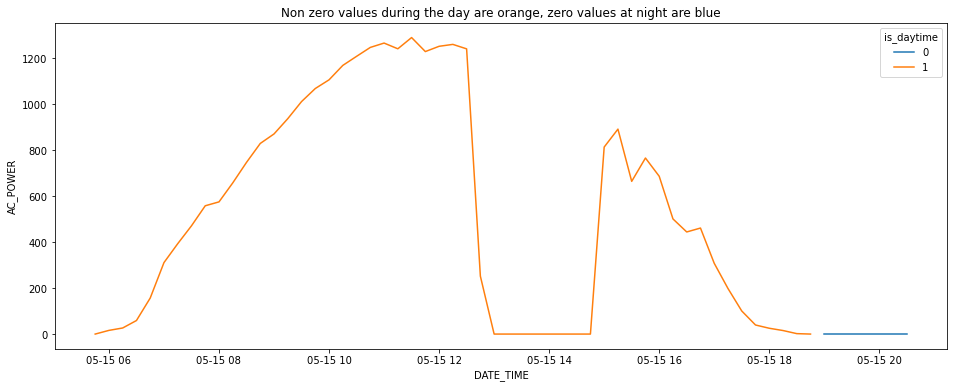

In [38]:
f = plt.figure(figsize=(16, 6))
sns.lineplot(
    data=train_df[train_df['SOURCE_KEY'] == 'oZ35aAeoifZaQzV'].sort_index()[23:83], 
    x="DATE_TIME", 
    y="AC_POWER", 
    hue='is_daytime'
).set(title='Non zero values during the day are orange, zero values at night are blue')
f.show()

## Save training and test data

In [15]:
train_df.to_csv('processed_data/train_df.csv')  
test_df.to_csv('processed_data/test_df.csv')  

In [18]:
train_df.head(10)

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,WEATHER_SOURCE,DATE,TIME,is_daytime,yesterday_plant_temperature,yesterday_max_daily_yield
DATE_TIME,,,,,,,,,,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.000000,0.000000,0.000000,6.259559e+06,25.184316,22.857507,0.000000,HmiyD2TTLFNqkNe,2020-05-15,00:00:00,0,0.0,NaN
2020-05-15 15:45:00,4136001,oZ35aAeoifZaQzV,782.357143,765.842857,6301.500000,1.659971e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,mqwcsP2rE7J0TFp,739.653333,724.226667,8703.800000,5.935887e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,WcxssY2VbP4hApt,770.320000,754.113333,8870.866667,1.817041e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,V94E5Ben1TlhnDV,760.442857,744.478571,8618.285714,1.412092e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,Quc1TzYxW2pYoWX,602.326667,590.186667,3627.066667,3.295127e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,Qf4GUc1pJu5T6c6,760.050000,744.078571,5636.571429,8.384270e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,PeE6FRyGXUgsRhN,734.078571,718.792857,8407.428571,1.348359e+09,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN
2020-05-15 15:45:00,4136001,NgDl19wMapZy17u,745.380000,729.793333,8729.066667,1.115213e+08,36.755735,44.975190,0.505614,iq8k7ZNt4Mwm3w0,2020-05-15,15:45:00,1,NaN,NaN


---